# PH526x Final Project

>**Author**: Hynek Buček, 3uky 

## Introduction

The final project is focused on prediction of the human physical activity (walking, standing, ascending and descending stairs) based on data from tri-axial smartphone accelerometer.

### Input Dataset
Input dataset contains training and test data in csv format each set consists of two csv files:

- The first training file [train_time_series.csv](https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv) contains accelerometer data. There are 1250 records sampled every 0.1 second. The file is used as input for classification model training. Every record has following features/columns.

    ```sample number, timestamp, UTC time, accuracy, x, y, z```

- The second training file [train_labels.csv](https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv) contains label column with integer values encoding the human physical activity (1=standing, 2=walking, 3=descending, 4=ascending). There are just 125 records and sampling rate is 1 second so there are 10 times less records then in previous training csv file. Every record has following features.

    ```sample number, timestamp, UTC time, label```

Test data consists of two csv files [test_time_series.csv](https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv) and [test_labels.csv](https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv) with same structure, sampling rate and number of records as training dataset. The *test_time_series.csv* is used as input for classification model. Based on predicted labels is necessary determine final labels in *test_labels.csv*. The *test_labels.csv* is final result the main goal of this project and completed file has to be submitted.

### Project Goal

The goal is to classify different physical activities as accurately as possible. The classification model would be created based on training input data (supervised machine learning) and the model would be used for test data classification. Part of this project is also creation of this Jupyter Lab report and run-time measurement. 

### Main Steps
1. data analysis
2. data preprocessing (data cleaning, data balancing, determine labels for test_time_series.csv, additional covariates computation)
3. covarites specification (accuracy x, y, z and magnitude)
4. models scoring (best score has random forest classifier)
5. model training
6. input data classification
7. result data augmentation (knn smoothing)

## Methods

### Input Dataset Analysis

I have analysed csv files structure and values. The *train_time_series.csv* and *train_labes.csv* have different sampling times. It's possible to extract labels from *train_labels.csv* because label values are consistent in time and activity state is changing every several seconds not miliseconds.

The test data from *test_time_series.csv* would be used as input data for classification. A result would be necessary augmented because of diffrent sampling rate in *test_labels.csv*. I have decided use knn classifier with 10 neighbors the final label would be selected based on timestamp and majority vote of 10 closest predicted labels.

I have checked github projects related to HAR "Human Activity Recognition" with use of acceleration measurements and found that is possible to calculate acceleration magnitude from x, y, z accuracy and used it as training covariate. The magnitude equation is as follow:

m = $\sqrt{x^2 + y^2 +z^2}$

### Methodology Overview
1. The *training_labels.csv* contain labels for every 10 observations in *training_time_series.csv*. Missing labels could be determined based on closest timestamp.
2. Based on data analysis I have used *x, y, z* accuracy and calculated *magnitude* as model training covariates.
3. I have found that training data are Imbalanced. I have partially solved this issue with over-sampling. I have used *confusion matrix* for re-sampling result verification.
4. I have score several classification models with *cross-validation* and *batch_classify* and found that *random forest classifier* has best result. I have trained model with provided post-processed input data. 
5. I was experimenting with manual prediction, splitting train dataset on train and validation data and used them for model training and prediction verification.
6. I have predicted labels of input data *test_time_series.csv* based on trained model.
7. Predicted data were re-sampled with *K-nearest neighbor* classifier and stored in *test_lables.csv* files. The result is presented also as graph and as list of labels.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Data Analysis - train_labels.csv

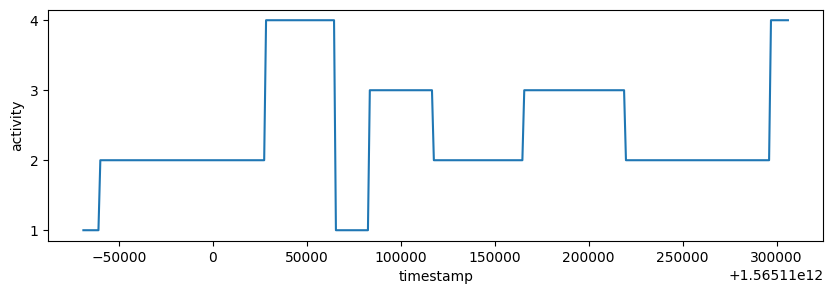

In [2]:
def plot_xy(x, y, y_title="acceleration"):
    fig = plt.figure(figsize=(10, 3))
    plt.xlabel("timestamp")
    plt.ylabel(y_title)
    plt.plot(x, y)
    plt.show()

def plot_activity(x, y, title=''):
    fig = plt.figure(figsize=(10, 3))
    plt.xlabel("timestamp")
    plt.ylabel("activity")
    plt.plot(x, y)
    #plt.yticks([1, 2, 3, 4], ["standing", "walking", "stairs down", "stairs up"])
    plt.yticks([1, 2, 3, 4])    
    plt.title(title)
    plt.show()
    
df_labels = pd.read_csv('data/train_labels.csv', usecols=["timestamp", "label"])

# labels/activities are consistent in time
plot_activity(df_labels.timestamp, df_labels.label)

### Data Analysis - train_time_series.csv

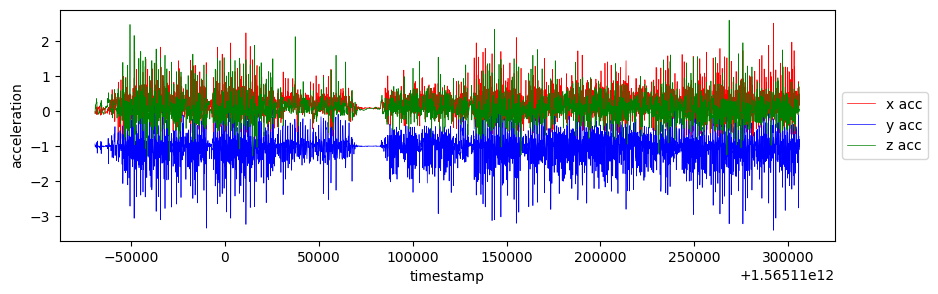

In [3]:
def plot_data(df):
    selection = df.iloc[:]
    plt.figure(figsize=(10,3))
    plt.plot(selection.timestamp, selection.x, linewidth=0.5, color='r', label='x acc')
    plt.plot(selection.timestamp, selection.y, linewidth=0.5, color='b', label='y acc')
    plt.plot(selection.timestamp, selection.z, linewidth=0.5, color='g', label='z acc')
    plt.xlabel('timestamp')
    plt.ylabel('acceleration')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show

# reading training csv data
df_train = pd.read_csv('data/train_time_series.csv', usecols=["timestamp","x","y","z"])

plot_data(df_train)

### Data Procesing

I have created magnitude from accuracy values. The labels could be determined from *train_labels.csv* file based on closest timestamp. It's necessary to **duplicate relevant labels** because of different sampling rate. This data processing is possible due to fact that human activity is changing every several seconds not every several milliseconds, it's visible also on activity graph from *train_labels.csv*.

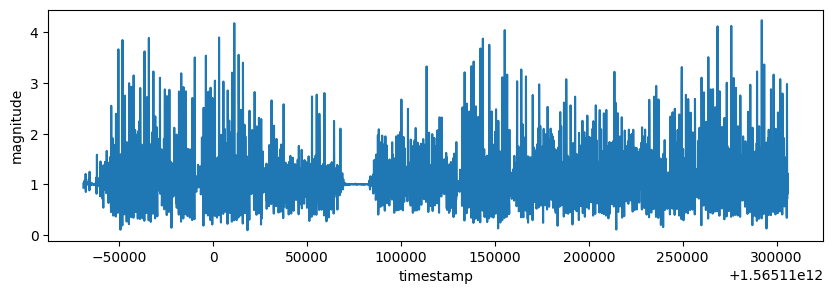

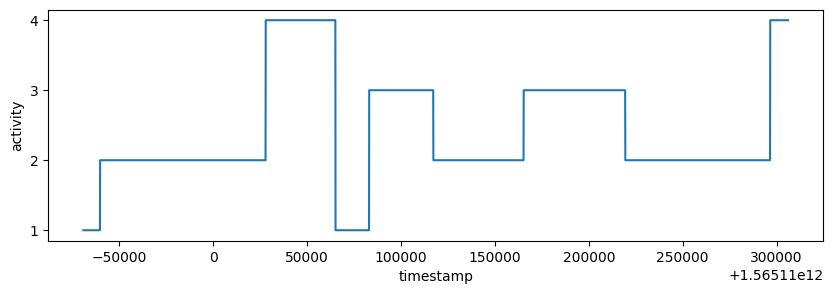

In [4]:
def add_magnitude(df):
    df['m'] = np.sqrt(df.x**2 + df.y**2 + df.z**2)

# read labels from train_labels.csv and set label value in train_time_series data frame based on nearest timestamp value
def add_label(df_train):
    df_train['label'] = df_train['timestamp'].map(lambda timestamp: get_label(df_labels, timestamp))
    
def get_label(df_labels, timestamp):
    timestamps = np.asarray(df_labels.timestamp)
    idx = (np.abs(timestamps - timestamp)).argmin()
    return df_labels.iloc[idx].label

# calculate new columns
add_magnitude(df_train)
add_label(df_train)

plot_xy(df_train.timestamp, df_train.m, "magnitude")
plot_activity(df_train.timestamp, df_train.label)

I have created 3d plots for accelerations and color them by assigned label. There is visible some clustering but acceleration values of different labels are overlaying. I think it's because human activity cannot be predicted based on single axis accuracy but on their combination.

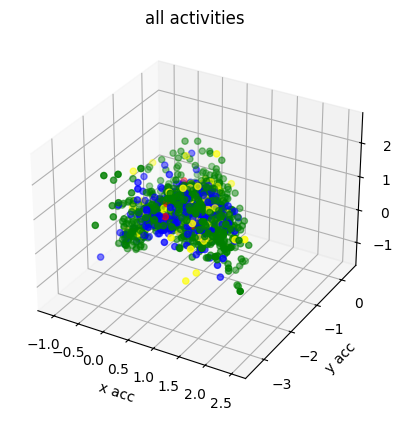

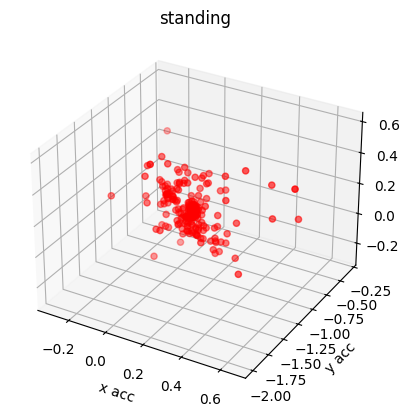

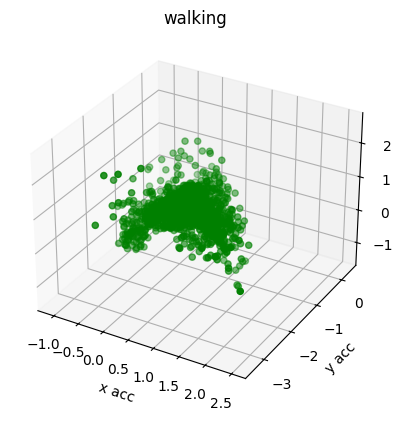

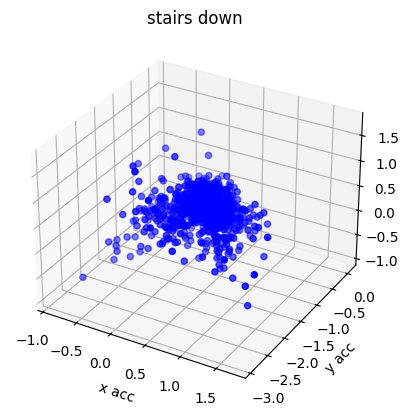

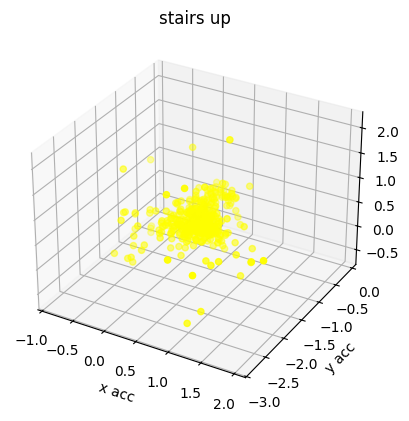

In [5]:
from mpl_toolkits.mplot3d import Axes3D

def plot_xyz(selection, title=''):
    #print(selection)
    colors = {1:'red', 2:'green', 3:'blue', 4:'yellow'}
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax = Axes3D(fig)
    ax.set_title(title)
    ax.set_xlabel('x acc')
    ax.set_ylabel('y acc')
    ax.set_zlabel('z acc')
    ax.scatter(selection.x, selection.y, selection.z, c=selection.label.map(colors));

# 3d plot for all accuracies colored by it's labels
plot_xyz(df_train, "all activities")

# 3d plot for separated accuracies
for label_number,activity in {1:'standing', 2:'walking', 3:'stairs down', 4:'stairs up'}.items():
    plot_xyz(df_train[df_train.label == label_number], activity)

### Covariates Specification

Based on graph results the **acceleration** data has relation with labels. I have found from different github projects and scientific articles that **magnitude** could be used also as additional covariate for model training.

In [6]:
# Specify classification_outcome Y and covariates X
classification_target = 'label'
all_covariates = ['x', 'y', 'z', 'm']
Y = df_train[classification_target]
X = df_train[all_covariates]

### Data Processing - Imbalanced Data

There is un-even count of labels in training input dataset. Imbalanced classification is the problem of classification when there is an unequal distribution of classes. Imbalanced data could lead to classification bias. For solving of this problem I was experimenting with under/over sampling of training dataset. There is very large data lost with under-sampling and trained model provided unstable results. **Over-sampling** had better results but confusion matrix revealed that classification for classes 2, 3, 4 isn't precise.

In [7]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from siml.signal_analysis_utils import *

print("Imbalanced class distribution before re-sampling:\n{}".format(Y.value_counts()))

ros = RandomOverSampler()
X, Y = ros.fit_resample(X, Y)

print("Class distribution after re-sampling:\n{}".format(Y.value_counts()))

Imbalanced class distribution before re-sampling:
label
2    2130
3     881
4     465
1     268
Name: count, dtype: int64
Class distribution after re-sampling:
label
1    2130
2    2130
4    2130
3    2130
Name: count, dtype: int64


### Confusion Matrix

Confusion matrix could reflect more details on classification accuracy. Each row of the matrix represents the instances in actual class while each column represents the instances in a predicted class. This is very usefull for **verification of re-sampling** from previous step. I have better results with over-sampling than with under-sampling. I was trying also combination with sampling strategy but I didn't get much better results than with pure over-sampling.

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def generate_validation_data(X, Y):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, random_state=1)
    forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)
    forest_classifier.fit(X_train, Y_train)
    Y_pred = forest_classifier.predict(X_val)
    return Y_val, Y_pred

def evaluate_confusion_matrix(X, Y):
    Y_val, Y_pred = generate_validation_data(X, Y)
    cm = confusion_matrix(Y_val, Y_pred, normalize="true")

    print(cm)    
    print("Average diagonal precision {:.2f}%".format(np.trace(cm)/4*100))

evaluate_confusion_matrix(X, Y)

[[0.84353741 0.04761905 0.04081633 0.06802721]
 [0.03517588 0.46482412 0.21356784 0.28643216]
 [0.05605381 0.29596413 0.43273543 0.21524664]
 [0.05011933 0.22434368 0.20286396 0.52267303]]
Average diagonal precision 56.59%


### Model Score

Cross validation score of **random forest classifier** has much better results than *logistic regression*. I have used also `batch_classify` and *random forest* has best score from all models.

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from siml.sk_utils import *

def model_accuracy(estimator, X, y):
    estimator.fit(X, y)
    predictions = estimator.predict(X)
    return accuracy_score(y, predictions)

def score_classifier(classifier, X, Y):
    score = cross_val_score(classifier, X, Y, cv=10, scoring=model_accuracy)
    print(classifier)
    print("mean score:", np.mean(score))

# instanciate classifers
logistic_regression = LogisticRegression()
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)

# evaluate a score by cross-validation
score_classifier(logistic_regression, X, Y)
score_classifier(forest_classifier, X, Y)


# split train data on training and testing in ration 8:2
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, random_state=1)

# check score for different models
models = batch_classify(X_train, Y_train, X_val, Y_val)
display_dict_models(models)

LogisticRegression()
mean score: 0.4390845070422535
RandomForestClassifier(max_depth=4, random_state=0)
mean score: 0.6539906103286384
trained Gradient Boosting Classifier in 3.20 s
trained Random Forest in 1.02 s
trained Logistic Regression in 0.10 s
trained Nearest Neighbors in 0.00 s
trained Decision Tree in 0.02 s


,classifier,train_score,test_score,train_time
1,Random Forest,1.000000,0.883216,1.019190
4,Decision Tree,1.000000,0.869718,0.024977
3,Nearest Neighbors,0.831719,0.715376,0.004526
0,Gradient Boosting Classifier,0.733862,0.685446,3.198237
2,Logistic Regression,0.450411,0.451291,0.097219


### Model Training

In [10]:
forest_classifier.fit(X, Y)

RandomForestClassifier(max_depth=4, random_state=0)

### Test Data Classification

I have calculate *magnitude* for input test data and predict labels with help of *random forest classification* model.

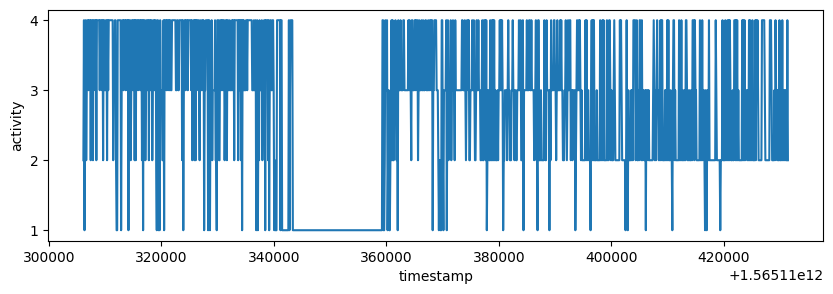

In [11]:
# load test data
df_test = pd.read_csv('data/test_time_series.csv', usecols=["timestamp","x","y","z"])

# data preprocessing
add_magnitude(df_test)

# classification
test_covariates = df_test[all_covariates]
df_test["label"] = forest_classifier.predict(test_covariates)

# check result in plot
plot_activity(df_test.timestamp, df_test.label)

### Final Data Processing

Predicted values are sampled with **K-nearest neighbor classifier**. I have selected *10 neighbors* becouse of sampling rate is 1:10 it means that one final sample in *test_labels.csv* corresponds to 10 predicted labels made from *test_time_series.csv* (`df_test`).

In [12]:
from sklearn.neighbors import KNeighborsClassifier

def smooth_knn(df_train, df_test, n_neigh=50):
    neigh = KNeighborsClassifier(n_neighbors=n_neigh)
    neigh.fit(df_train.timestamp.values.reshape(-1, 1), df_train.label)
    return neigh.predict(df_test.timestamp.values.reshape(-1, 1))

# load test_labels
df_test_labels = pd.read_csv('data/test_labels.csv', index_col=0)

# smoothing result with knn (10 becouse there are 10 samples in test_time_series.csv on 1 sample in test_labels.csv)
df_test_labels["label"] = smooth_knn(df_test, df_test_labels, n_neigh=10)
label_knn_1 = smooth_knn(df_test, df_test_labels, n_neigh=1)

## Results

The result contains lot of fast changing activities however characteristic similar to *train_labels.csv* is expected so there are some false classifications. It's possible to smooth result with more higher neighbors parameter but it would introduce errors in result. The better data pre-processing or data balancing could be better way how to improve the final result. Unfortunatly I have exhaused my accuracy validation tries so I have decided to ignore result inaccury in this point.

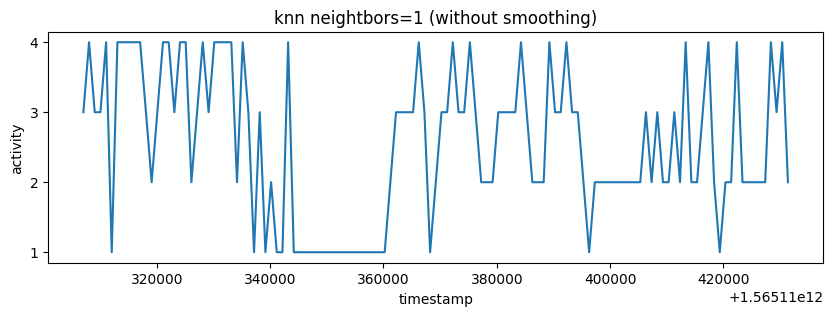

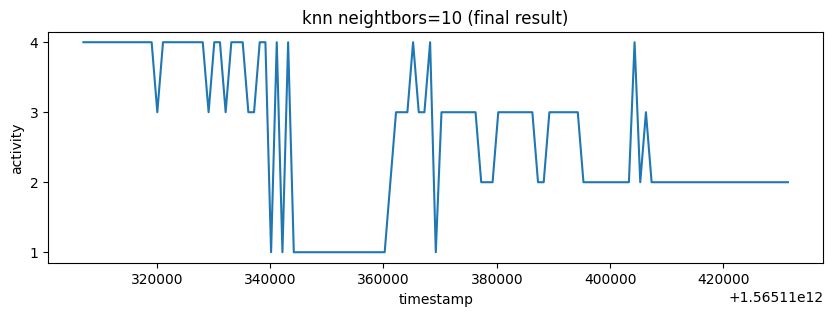

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 3, 4, 4, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 4, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [13]:
def accuracy(predictions, Y_val):
    return 100*np.mean(predictions == Y_val)

# print results
plot_activity(df_test_labels.timestamp, label_knn_1, "knn neightbors=1 (without smoothing)")
plot_activity(df_test_labels.timestamp, df_test_labels.label, "knn neightbors=10 (final result)")
result_labels = df_test_labels.label.tolist()
#print("Similarity between knn 1 and 10 is {}%".format(accuracy(df_test_labels.label_knn_1, df_test_labels.label)))

print(result_labels)

# Store result into test_labels.csv
df_test_labels.to_csv("data/test_labels.csv")

### Notes - history of measurment

I experimented with data pre-procesing (`np.convolve`) but my result accuracy decreased, later I figured out that it was probably because of random characteristic of training data after re-sampling.

In [14]:
# acc=67.2% (x_smooth, y_smooth, z_smooth covariates smoothing (len/25) train, test, knn(50) smoothing of predictors)
try1 = [2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 1, 1, 1]
# acc=69.6% (xy_smooth, z_smooth covariates smoothing (len/25)train, test, knn(105) smoothing of predictors)
try2 = [1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4]
# acc=72%
try3 = [4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2]
# acc=64% (try2 with smoothing)
try4 = [4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1]
# acc=72% over-sampling + knn n_neigh=10
try5 = try3

#print("similarity last try to actual try {}%".format(accuracy(np.array(try3), np.array(result_labels))))
#plot_activity(df_test_labels.timestamp, try1)
#plot_activity(df_test_labels.timestamp, try2)
#plot_activity(df_test_labels.timestamp, try3)
#plot_activity(df_test_labels.timestamp, try4)
#plot_activity(df_test_labels.timestamp, try5)
#plot_activity(df_test_labels.timestamp, result_labels)

### Notes - time measurment

For run-time measurement I have used code without data analysis, data presentation, data verification and model score because those steps are not necessary for data processing and classification itself. The result code is as follow:

```Python
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from siml.sk_utils import *
from sklearn.neighbors import KNeighborsClassifier
import warnings

import time

def add_magnitude(df):
    df['m'] = np.sqrt(df.x ** 2 + df.y ** 2 + df.z ** 2)

# read labels from train_labels.csv and set label value in train_time_series data frame based on nearest timestamp value
def add_label(df_train):
    df_train['label'] = df_train['timestamp'].map(lambda timestamp: get_label(df_labels, timestamp))

def get_label(df_labels, timestamp):
    timestamps = np.asarray(df_labels.timestamp)
    idx = (np.abs(timestamps - timestamp)).argmin()
    return df_labels.iloc[idx].label

def smooth_knn(df_train, df_test, n_neigh=50):
    neigh = KNeighborsClassifier(n_neighbors=n_neigh)
    neigh.fit(df_train.timestamp.values.reshape(-1, 1), df_train.label)
    return neigh.predict(df_test.timestamp.values.reshape(-1, 1))

warnings.filterwarnings('ignore')

start_time = time.process_time()

df_labels = pd.read_csv('data/train_labels.csv', usecols=['timestamp', 'label'])
df_train = pd.read_csv("data/train_time_series.csv", usecols=['timestamp', 'x', 'y', 'z'])

add_magnitude(df_train)
add_label(df_train)

Y = df_train['label']
X = df_train[['x', 'y', 'z', 'm']]

ros = RandomOverSampler()
X, Y = ros.fit_resample(X, Y)

forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)
forest_classifier.fit(X, Y)

df_test = pd.read_csv('data/test_time_series.csv', usecols=['timestamp', 'x', 'y', 'z'])
add_magnitude(df_test)
test_covariates = df_test[['x', 'y', 'z', 'm']]
df_test['label'] = forest_classifier.predict(test_covariates)

df_test_labels = pd.read_csv('data/test_labels.csv', usecols=['timestamp', 'label'])
df_test_labels['label'] = smooth_knn(df_test, df_test_labels, n_neigh=10)

df_test_labels.to_csv('data/test_labels.csv')

end_time = time.process_time()
print(end_time - start_time)
```

|measurment no. |time \[seconds\] |
--- | :--- 
|1|0.9990438859999997|
|2|1.018831239|
|3|1.0244850099999998|
|4|1.07471765|
|5|1.02071244|
|6|1.062620566|
|7|1.054131953|
|8|1.056807737|
|9|1.0656584949999999|
|10|1.02055073|


In [15]:
times = np.array([0.9990438859999997,1.018831239,1.0244850099999998,1.07471765,1.02071244,1.062620566,1.054131953,1.056807737,1.0656584949999999,1.02055073])
print("Average run-time of data processing and classification is {} seconds.".format(np.average(times)))

Average run-time of data processing and classification is 1.0397559706 seconds.


## Conclusion

I have classified input data with *random forest classification* model. Predicted labels were re-sampled with *K-nearest neighbor classifier*. I have reached classification accuracy of **72%**. Accuracy could be improved with better data pre-processing, data balancing or hyperparameter tuning. I have also documented all analysis and verification steps and program run-time. The final project was fun.